# Road Lane Lines Curves Detection

This project is inspired from Udacity's project ["Finding Lane Lines on the Road"](https://github.com/udacity/CarND-LaneLines-P1) part of Self-Driving Car Engineer ND.


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
import numpy as np
import cv2
%matplotlib inline

# Pictures

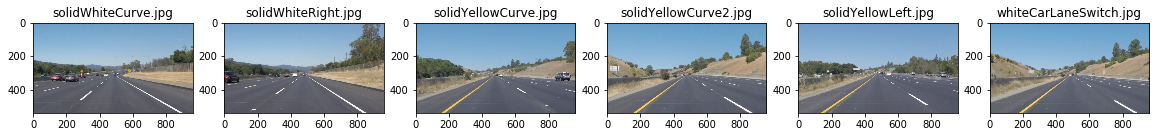

In [2]:
#checking the images within the test images folder.
images = []
names = []

for i in glob.glob('test_images/*.jpg'):
    images.append(mpimg.imread(i))

for filename in glob.glob('test_images/*.jpg'):
    names.append(os.path.basename(os.path.normpath(filename)))

plt.figure(figsize=(20,5))
columns = len(images)
for t, (name, image) in enumerate(zip(names, images)):
    plt.subplot(len(images) / columns +1, columns, t+1)
    plt.title(name)
    plt.imshow(image)

## Building the algorithm to detect lines
I'm focusing on the 1st solidWhiteCurve

(540, 960, 3)


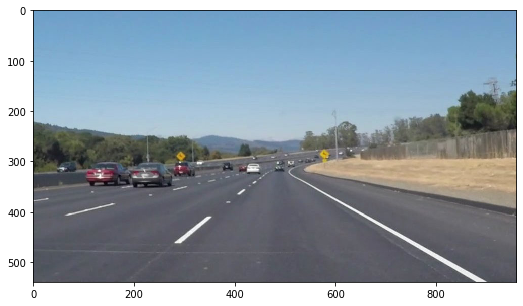

In [3]:
plt.figure(figsize=(15,5))
fimage = mpimg.imread('test_images/solidWhiteCurve.jpg')
print(fimage.shape)
plt.imshow(fimage)

### Grayscale transform to reduce noise (here color)

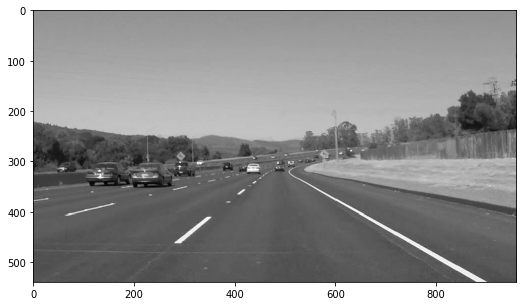

In [4]:
plt.figure(figsize=(10,5))

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
imgr = grayscale(fimage)
plt.imshow(imgr, cmap='gray')

### Canny for edge detection
**This the mandatory contour extraction step.**<br>
Edges with intensity gradient more than high_threshold are edges!<br>
Edges with intensity gradient below than low_threshold are non-edges!<br>
Edges with intensity gradient in between low and high threshold are classified edges or non-edges based
on their connectivity with the classified edges.

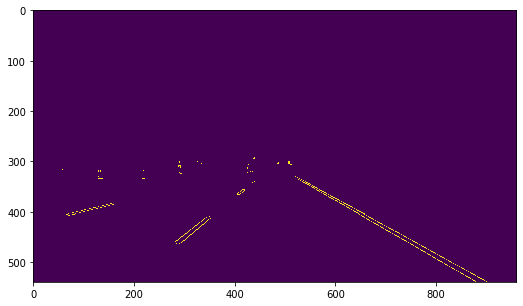

In [5]:
plt.figure(figsize=(10,5))

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

imcann = canny(imgr, 385, 550)
plt.imshow(imcann)

### Gaussian_Blur to remove high frequency content (noise, edges).
This actually is smoothing the input image.

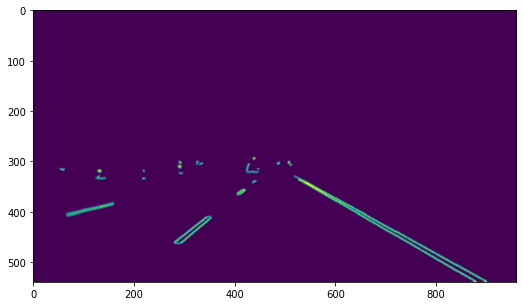

In [6]:
plt.figure(figsize=(10,5))

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

imgauss = gaussian_blur(imcann, 7)
plt.imshow(imgauss)

### Region_of_interest
1. Mask step: defining a blank mask
2. Filling step: filling up the area with the data we want
3. Mixing step: bitwise_and the input image with the transormed image

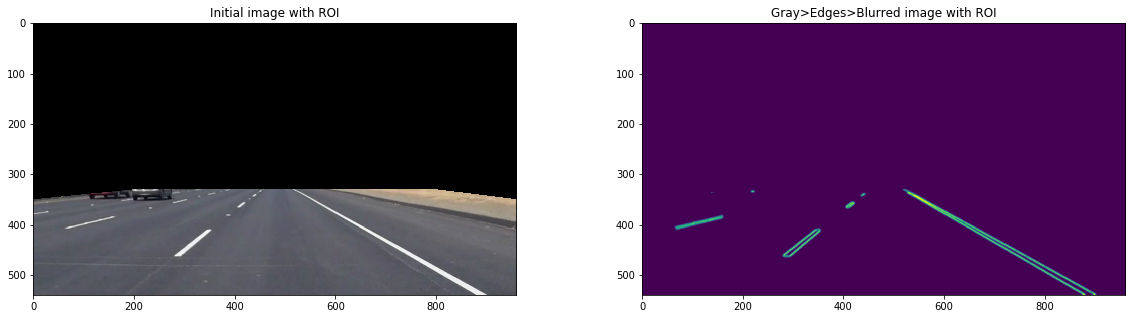

In [7]:
def roi(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    # Mask step
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # in our case 3, recall the shape of the image (540, 960, 3)
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # Filling step: filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    # Mixing step: returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# recall the shape of the image (540, 960, 3)
vertices = np.array([[0,540],[0,350], [200,330], [800,330], [960,350], [960,540]], np.int32)

imroi_1 = roi(fimage, [vertices])
imroi_2 = roi(imgauss, [vertices])

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Initial image with ROI")
plt.imshow(imroi_1)
plt.subplot(1,2,2)
plt.title("Gray>Edges>Blurred image with ROI")
plt.imshow(imroi_2)

### Hough Line transformation to detect shape
Actually, for each pixel within the contour, the algorithm is considering all the possible lines passing through the pixel.<br>
Hough Line uses the representation of line in the parametric form with (rho, theta).
<br><br>
But first, **we need to Draw lines.**

In [8]:
def draw_lines(img, lines, color=[0, 255, 0], thickness=2):
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

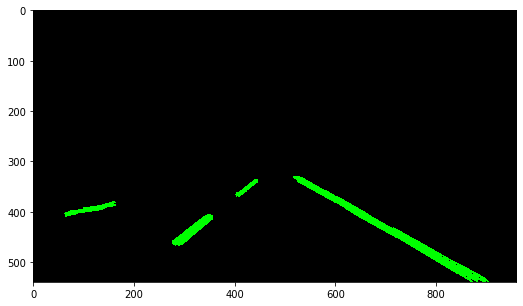

In [9]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

rho = 4 # max rho is the diagonal of the picture
theta = np.pi/180
threshold = 180
min_line_len = 10
max_line_gap = 20
imhl = hough_lines(imroi_2,rho, theta, threshold, min_line_len, max_line_gap)

plt.figure(figsize=(20,5))
plt.imshow(imhl)

### Layers overlay
Layer 1: transformed image from lane line pipeline<br>
Layer 2: initial image

In [10]:
def weighted_img(src1, src2, α=0.8, β=0, γ=0.):
    return cv2.addWeighted(src1, α, src2, β, γ)

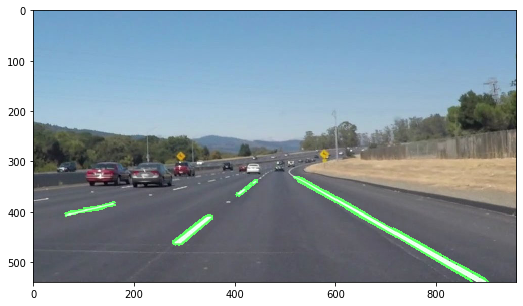

In [11]:
plt.figure(figsize=(20,5))

# α for weighted of the transformed image.
# β for weighted of the initial image.
# γ scalar added to each sum.

layov = weighted_img(imhl, fimage, 1, 1, 0.0)
plt.imshow(layov)

## Test the pipeline on each test images

In [18]:
# shortened the pipeline
def llc_detector(road):
    viz = mpimg.imread(road)
    new_viz = grayscale(viz) # gray
    can_viz = canny(new_viz, 315, 470) # edges
    gauss_viz = gaussian_blur(can_viz, 7) # smoothness
    
    vertices = np.array([[0,540],[0,350], [200,330], [800,330], [960,350], [960,540]], np.int32)
    
    roi_viz = roi(gauss_viz, [vertices]) # region of interest
    rho = 4 # max rho is the diagonal of the picture
    theta = np.pi/180
    threshold = 180
    min_line_len = 10
    max_line_gap = 20
    
    new_viz = hough_lines(roi_viz, rho, theta, threshold, min_line_len, max_line_gap)
    fusion = weighted_img(new_viz, viz, 1, 1, 0.0)
    return weighted_img(new_viz, viz, 1, 1, 0.0)  # fusion  # plt.imshow(fusion)

<Figure size 720x360 with 0 Axes>

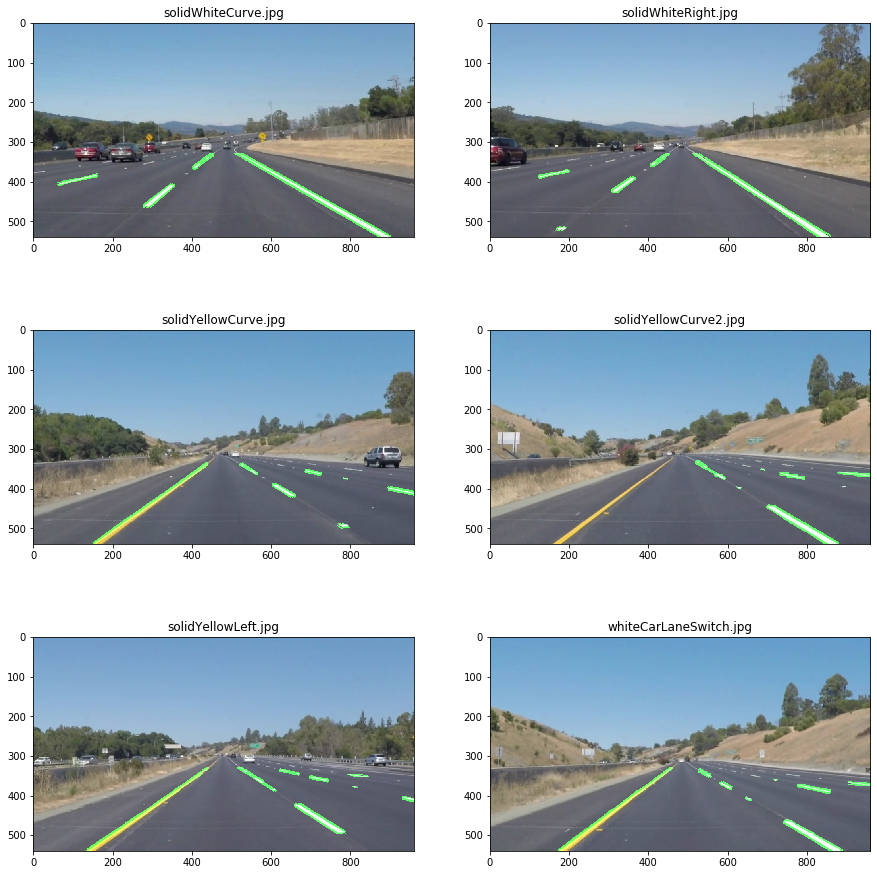

In [21]:
plt.figure(figsize=(10,5))


def show_All(path):
    images = []
    names = []
    for i in glob.glob(path):
        images.append(llc_detector(i))

    for filename in glob.glob(path):
        names.append(os.path.basename(os.path.normpath(filename)))

    fig = plt.figure(figsize=(15,16)) 
    # columns = len(images)
    for t, (name, image) in enumerate(zip(names, images)):
        # plt.subplot(1, len(images), 1+t)
        fig.add_subplot(3, 2, t+1)
        plt.title(name)
        plt.imshow(image)
        plt.savefig('test_images_output/'+ name, dpi = 72, bbox_inches='tight')

# showing all the test images
show_All('test_images/*.jpg')

### When the line is curved, the detector failed partially, see. solidYellowCurve.jpg vs solidYellowCurve2.jpg

# Videos

In [25]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
def llc_detector(viz):
    # viz = mpimg.imread(road) # process_image(mpimg.imread(image))
    new_viz = grayscale(viz) # gray
    can_viz = canny(new_viz, 315, 470) # edges
    gauss_viz = gaussian_blur(can_viz, 7) # smoothness
    
    vertices = np.array([[0,540],[0,350], [200,330], [800,330], [960,350], [960,540]], np.int32)
    
    roi_viz = roi(gauss_viz, [vertices]) # region of interest
    rho = 4 # max rho is the diagonal of the picture
    theta = np.pi/180
    threshold = 180
    min_line_len = 10
    max_line_gap = 20
    
    new_viz = hough_lines(roi_viz, rho, theta, threshold, min_line_len, max_line_gap)
    fusion = weighted_img(new_viz, viz, 1, 1, 0.0)
    return weighted_img(new_viz, viz, 1, 1, 0.0)  # fusion  # plt.imshow(fusion)

In [35]:
white_line = 'test_videos_output/solidWhiteLine.mp4'

vInput = VideoFileClip('test_videos/solidYellowLeft.mp4')
video_llcD = vInput.fl_image(llc_detector)
video_llcD.write_videofile(white_line, audio=False)

t:   2%|▏         | 11/681 [00:00<00:06, 102.38it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteLine.mp4.
Moviepy - Writing video test_videos_output/solidWhiteLine.mp4




t:   0%|          | 1/681 [10:18<116:55:14, 618.99s/it, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteLine.mp4


In [32]:
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(white_line))

In [36]:
challenge_line = 'test_videos_output/challenge.mp4'

vcInput = VideoFileClip('test_videos/challenge.mp4')
cvideo_llcD = vcInput.fl_image(llc_detector)
%time cvideo_llcD.write_videofile(challenge_line, audio=False)

t:   2%|▏         | 5/251 [00:00<00:05, 44.98it/s, now=None]

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4




t:   0%|          | 1/681 [10:40<120:53:53, 640.05s/it, now=None]

Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 7.49 s, sys: 2.36 s, total: 9.86 s
Wall time: 8.22 s


**Let's test the algorithm on the 'challenge' video.**

In [37]:
HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(challenge_line))

Well, some fine tuning on parameters needs to be done but also some improvements for more adaptativity.<br> For instance, ```vertices = np.array([[0,540],[0,350], [200,330], [800,330], [960,350], [960,540]], np.int32``` which have been set on the test_images size won't fit with another size of input (image, video).<br>Thus, scalar needs to be apply to input.shape (image or video) like ```vertices = np.array([[(0,imageshape[0]), (imageshape[1] * 0.xx,```

# Improvement

Extended straight line instead of shortened lines (see. P1_example video)

In [39]:
example = 'examples/P1_example.mp4'

HTML("""<video width="480" height="270" controls><source src="{0}"></video>""".format(example))

# WIP
To reach the render above, there is a need to find the averaged line when there are multiple lines detected and extrapolate the small lines to then create a continuous lines.